# Project: Predicting Credit Card Approvals

## Instructions

- Summarize the data with `describe()` on `cc_apps` and then split the data into `cc_apps_train` and `cc_apps_test`.
- Impute the missing values contained in the dataset.
- Preprocess the data by encoding the categorical features.
- Segregate features and labels for training and testing: `X_train`, `y_train`, `X_test`, and `y_test`. Then rescale the training and testing features contained in `X_train` and `X_test`: `rescaledX_train` and `rescaledX_test`.
- Train a logistic regression classifier `logreg` on (`rescaledX_train`, `y_train`) and evaluate on (`rescaledX_test`, `y_test`).
- Perform hyperparameter tuning with a `GridSearchCV` object: `grid_model`. Once the grid-search process in completed, extract the best model and the best performance score yielded from `grid_model`.

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, we will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

![Credit card being held in hand](./credit_card.jpg)

You have been provided with a small subset of the credit card applications a bank receives. The dataset has been loaded as a Pandas DataFrame for you. You will start from there. 

# 1. Import the data

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 
cc_apps.head(n=85)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.250,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.040,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.500,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.750,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0,f,s,00120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,b,49.58,19.000,u,g,ff,ff,0.000,t,t,1,f,g,00094,0,-
81,a,27.67,1.500,u,g,m,v,2.000,t,f,0,f,s,00368,0,-
82,b,39.83,0.500,u,g,m,v,0.250,t,f,0,f,s,00288,0,-
83,a,?,3.500,u,g,d,v,3.000,t,f,0,t,g,00300,0,-


# 2. Investigate the data

In [2]:
cc_apps.describe()

,2,7,10,14
count,690.000000,690.000000,690.00000,690.000000
mean,4.758725,2.223406,2.40000,1017.385507
std,4.978163,3.346513,4.86294,5210.102598
min,0.000000,0.000000,0.00000,0.000000
25%,1.000000,0.165000,0.00000,0.000000
50%,2.750000,1.000000,0.00000,5.000000
75%,7.207500,2.625000,3.00000,395.500000
max,28.000000,28.500000,67.00000,100000.000000


In [3]:
# Here we see the data only shows summaries of the numerical type data as we confirm with this:
cc_apps.dtypes

0      object
1      object
2     float64
3      object
4      object
5      object
6      object
7     float64
8      object
9      object
10      int64
11     object
12     object
13     object
14      int64
15     object
dtype: object

**However the data for form of the columns e.g. column 1 look numeric?**

In [4]:
cc_apps.isna().any()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
dtype: bool

In [5]:
cc_apps.isnull().any()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
dtype: bool

Changing the head to show 85 rows we can see why column 1 is an object:

```
83	a	?	3.500	u	g	d	v	3.000	t	f	0	t	g	00300	0	-
```

Note the '?'

We need to convert ? to NaN

In [6]:
cc_apps = cc_apps.replace('?',np.NaN)

In [7]:
# Now we can see we have sorted the lack of NaN as ? was used in the source data
cc_apps.isna().any()

0      True
1      True
2     False
3      True
4      True
5      True
6      True
7     False
8     False
9     False
10    False
11    False
12    False
13     True
14    False
15    False
dtype: bool

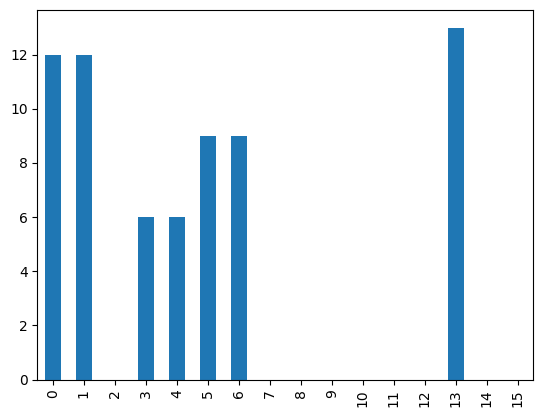

In [8]:
# We can summarise the missing data in a plot
import matplotlib.pyplot as plt
cc_apps.isna().sum().plot(kind='bar')
plt.show()

In [9]:
# As we have little missing data we could in theory just drop the missing data
cc_apps_dropna = cc_apps.dropna()
print(cc_apps_dropna.shape)
# out of 690 we have only lost a small amount so this is probably ok but the guide says to impute them

(653, 16)


# 3. Split the data

Given we have been asked to impute the data we will define a `sklearn.impute.SimpleImputer` to fix our data 
but to avoid leakage we should first we should split our data with `sklearn.model_selection.train_test_split`

In [10]:

cc_apps_train, cc_apps_test = train_test_split(cc_apps, test_size=0.30, random_state=42)

In [11]:
cc_apps_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
178,a,18.42,9.250,u,g,q,v,1.210,t,t,4,f,g,00060,540,+
265,b,17.08,0.085,y,p,c,v,0.040,f,f,0,f,g,00140,722,-
352,b,22.50,11.500,y,p,m,v,1.500,f,f,0,t,g,00000,4000,-
529,b,43.25,25.210,u,g,q,h,0.210,t,t,1,f,g,00760,90,-
409,b,17.08,0.250,u,g,q,v,0.335,f,t,4,f,g,00160,8,-


In [12]:
cc_apps_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
178,a,18.42,9.250,u,g,q,v,1.210,t,t,4,f,g,00060,540,+
265,b,17.08,0.085,y,p,c,v,0.040,f,f,0,f,g,00140,722,-
352,b,22.50,11.500,y,p,m,v,1.500,f,f,0,t,g,00000,4000,-
529,b,43.25,25.210,u,g,q,h,0.210,t,t,1,f,g,00760,90,-
409,b,17.08,0.250,u,g,q,v,0.335,f,t,4,f,g,00160,8,-


In [13]:
# Extract the features and labels into X_train and y_train
X_train = cc_apps_train.iloc[:, :-1].values
y_train = cc_apps_train.iloc[:, -1].values
X_test = cc_apps_test.iloc[:, :-1].values
y_test = cc_apps_test.iloc[:, -1].values


In [14]:
# Look at the indexes and positions
def print_array_details(arr):
    for ci, cv in enumerate(arr):
        print(f'{ci=}  {cv=} {type(cv)}')

In [15]:
print_array_details(cc_apps_train[0])

ci=0  cv='a' <class 'str'>
ci=1  cv='b' <class 'str'>
ci=2  cv='b' <class 'str'>
ci=3  cv='b' <class 'str'>
ci=4  cv='b' <class 'str'>
ci=5  cv='b' <class 'str'>
ci=6  cv='a' <class 'str'>
ci=7  cv='b' <class 'str'>
ci=8  cv='b' <class 'str'>
ci=9  cv='a' <class 'str'>
ci=10  cv='a' <class 'str'>
ci=11  cv='b' <class 'str'>
ci=12  cv=nan <class 'float'>
ci=13  cv='b' <class 'str'>
ci=14  cv='a' <class 'str'>
ci=15  cv='b' <class 'str'>
ci=16  cv='a' <class 'str'>
ci=17  cv='a' <class 'str'>
ci=18  cv='b' <class 'str'>
ci=19  cv='b' <class 'str'>
ci=20  cv='b' <class 'str'>
ci=21  cv='a' <class 'str'>
ci=22  cv='b' <class 'str'>
ci=23  cv=nan <class 'float'>
ci=24  cv='b' <class 'str'>
ci=25  cv='a' <class 'str'>
ci=26  cv='a' <class 'str'>
ci=27  cv='b' <class 'str'>
ci=28  cv='b' <class 'str'>
ci=29  cv='a' <class 'str'>
ci=30  cv='a' <class 'str'>
ci=31  cv='b' <class 'str'>
ci=32  cv='b' <class 'str'>
ci=33  cv='a' <class 'str'>
ci=34  cv='b' <class 'str'>
ci=35  cv='b' <class 'str'

In [16]:
print_array_details(cc_apps_test[0])

ci=0  cv='a' <class 'str'>
ci=1  cv='a' <class 'str'>
ci=2  cv='b' <class 'str'>
ci=3  cv='b' <class 'str'>
ci=4  cv='b' <class 'str'>
ci=5  cv='b' <class 'str'>
ci=6  cv='b' <class 'str'>
ci=7  cv='b' <class 'str'>
ci=8  cv='b' <class 'str'>
ci=9  cv='b' <class 'str'>
ci=10  cv='a' <class 'str'>
ci=11  cv='a' <class 'str'>
ci=12  cv='b' <class 'str'>
ci=13  cv='b' <class 'str'>
ci=14  cv='a' <class 'str'>
ci=15  cv='b' <class 'str'>
ci=16  cv='b' <class 'str'>
ci=17  cv='a' <class 'str'>
ci=18  cv='b' <class 'str'>
ci=19  cv='b' <class 'str'>
ci=20  cv='a' <class 'str'>
ci=21  cv='b' <class 'str'>
ci=22  cv='a' <class 'str'>
ci=23  cv='b' <class 'str'>
ci=24  cv='b' <class 'str'>
ci=25  cv=nan <class 'float'>
ci=26  cv='b' <class 'str'>
ci=27  cv='b' <class 'str'>
ci=28  cv='a' <class 'str'>
ci=29  cv='b' <class 'str'>
ci=30  cv='b' <class 'str'>
ci=31  cv='b' <class 'str'>
ci=32  cv='b' <class 'str'>
ci=33  cv='a' <class 'str'>
ci=34  cv='b' <class 'str'>
ci=35  cv='a' <class 'str'>


# 4. Handle missing  data

- Impute the missing values contained in the dataset.

Previously we executed this code:

```py
cc_apps = cc_apps.replace('?',np.NaN)
```

to convert source data missing values represented by '?' to numpy Nan (not a number)

We now need to impute the missing data for now the strategy will be:

- convert categorical data missing to most frequent
- convert numerical data missing to the mean

In [17]:
# Missing values are question marks in the source data - converted to NaN
missing_data_columns = [0, 1, 3, 4, 5, 6, 13]

# Define which numeric columns are missing
missing_data_mean=[1] 

# Define which columns with missing data are categorical
missing_data_category=[0, 3, 4, 5, 6, 13]

**Important Notes:**

1. A pipeline runs in parallel and so we need to be careful about which transformers we make use of so they do not impact each other. I found that using `OneHotEncoder` with the `SimpleImputer` caused issues so this just handles imputing 
2. We need to ensure there is no leakage of most frequent or mean between test and train datasets and so we must have a separate `ColumnTransformer` for test and training.

In [18]:
# Import all the packages we need to do the data transforms
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Define the transformations we require for the features
imputing_transformers = transformers = [
    ('imp_mean', SimpleImputer(missing_values=np.NaN, strategy='mean'), missing_data_mean),
    ('imp_freq', SimpleImputer(missing_values=np.NaN, strategy='most_frequent'), missing_data_category)
]

# separate ColumnTransformer
column_imputing_train_tf = ColumnTransformer(transformers=imputing_transformers, remainder='passthrough')
column_imputing_test_tf = ColumnTransformer(transformers=imputing_transformers, remainder='passthrough')

X_train = column_imputing_train_tf.fit_transform(X_train)
X_test = column_imputing_test_tf.fit_transform(X_test)

In [19]:
# Look at the features
print(X_train)
print_array_details(X_train[0])

[[18.42 'a' 'u' ... 'f' 'g' 540]
 [17.08 'b' 'y' ... 'f' 'g' 722]
 [22.5 'b' 'y' ... 't' 'g' 4000]
 ...
 [37.58 'b' 'u' ... 'f' 'p' 0]
 [19.0 'b' 'y' ... 'f' 'g' 1]
 [18.67 'b' 'u' ... 'f' 'g' 38]]
ci=0  cv=18.42 <class 'float'>
ci=1  cv='a' <class 'str'>
ci=2  cv='u' <class 'str'>
ci=3  cv='g' <class 'str'>
ci=4  cv='q' <class 'str'>
ci=5  cv='v' <class 'str'>
ci=6  cv='00060' <class 'str'>
ci=7  cv=9.25 <class 'float'>
ci=8  cv=1.21 <class 'float'>
ci=9  cv='t' <class 'str'>
ci=10  cv='t' <class 'str'>
ci=11  cv=4 <class 'int'>
ci=12  cv='f' <class 'str'>
ci=13  cv='g' <class 'str'>
ci=14  cv=540 <class 'int'>


# 5. Handle categorical data

- Preprocess the data by encoding the categorical features.

Below I define all of the column locations of the different columns.

From the data above we can see what the missing data columns are and what types they are:

In [20]:
# List all of the columns that are categorical
categorical_data=[1, 2, 3, 4, 5, 6, 9, 10, 12, 13]

Before we start with the categorical labels within X lets sort the labels (y) as that is pretty simple.

We want to convert the '+' and '-' values to a 0 or 1 which we can build our model with

In [21]:
# check first 10 values of y_train before encoding
print(f'{" ".join([str(y) for y in y_train][0:10])}')

+ - - - - + + - - -


In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [23]:
# print the resulting classes from the label encoding - expect + and -
print(list(le.classes_))

# check the conversion approach i.e. what does +/- mean 1/0 or 0/1
# check first 10 values of y_train before encoding
print(f'{" ".join([str(y) for y in y_train][0:10])}')

['+', '-']
0 1 1 1 1 0 0 1 1 1


In [24]:
# we can now convert the y_test values using the same approach as the training set
y_test = le.fit_transform(y_test)

In [25]:
# Let's take a look at the number of categories for each so we can sense check the one hot encoding via number of columns created etc
total_categories = 0

for cat in categorical_data:
    print(f'Column {cat}: ')
    # extract the unique values in the column
    cv = np.unique(X_train[:, cat])
    print(f'   ===> {cv}')
    # keep track of the total number of categories so we can check this many one hot columns are generated
    total_categories += len(cv)

print(f'Total Categories = {total_categories}')

Column 1: 
   ===> ['a' 'b']
Column 2: 
   ===> ['l' 'u' 'y']
Column 3: 
   ===> ['g' 'gg' 'p']
Column 4: 
   ===> ['aa' 'c' 'cc' 'd' 'e' 'ff' 'i' 'j' 'k' 'm' 'q' 'r' 'w' 'x']
Column 5: 
   ===> ['bb' 'dd' 'ff' 'h' 'j' 'n' 'o' 'v' 'z']
Column 6: 
   ===> ['00000' '00017' '00020' '00022' '00024' '00028' '00040' '00043' '00045'
 '00049' '00050' '00052' '00060' '00062' '00070' '00073' '00076' '00080'
 '00086' '00088' '00092' '00093' '00094' '00096' '00099' '00100' '00102'
 '00108' '00112' '00120' '00128' '00129' '00130' '00132' '00136' '00140'
 '00144' '00152' '00154' '00160' '00163' '00164' '00167' '00170' '00171'
 '00174' '00176' '00178' '00180' '00181' '00186' '00188' '00195' '00200'
 '00202' '00204' '00208' '00210' '00211' '00212' '00216' '00220' '00224'
 '00225' '00228' '00232' '00239' '00240' '00253' '00254' '00256' '00260'
 '00263' '00268' '00272' '00274' '00276' '00280' '00290' '00300' '00303'
 '00309' '00311' '00312' '00320' '00330' '00340' '00350' '00352' '00360'
 '00370' '00371

Now we are ready to convert the categorical data

In [26]:
# Import all the packages we need to do the data transforms
from sklearn.preprocessing import OneHotEncoder

# Define the transformations we require for the features
column_category_tf = ColumnTransformer(transformers=[
        ('encoder', OneHotEncoder(sparse_output=False, handle_unknown = 'ignore'), categorical_data),
], remainder='passthrough')

column_category_tf.fit(X_train)

X_train = column_category_tf.transform(X_train)

In [27]:
# Look at the features
print(X_train)
print_array_details(X_train[0])

[[1.0 0.0 0.0 ... 1.21 4 540]
 [0.0 1.0 0.0 ... 0.04 0 722]
 [0.0 1.0 0.0 ... 1.5 0 4000]
 ...
 [0.0 1.0 0.0 ... 0.0 0 0]
 [0.0 1.0 0.0 ... 0.0 4 1]
 [0.0 1.0 0.0 ... 0.375 2 38]]
ci=0  cv=1.0 <class 'float'>
ci=1  cv=0.0 <class 'float'>
ci=2  cv=0.0 <class 'float'>
ci=3  cv=1.0 <class 'float'>
ci=4  cv=0.0 <class 'float'>
ci=5  cv=1.0 <class 'float'>
ci=6  cv=0.0 <class 'float'>
ci=7  cv=0.0 <class 'float'>
ci=8  cv=0.0 <class 'float'>
ci=9  cv=0.0 <class 'float'>
ci=10  cv=0.0 <class 'float'>
ci=11  cv=0.0 <class 'float'>
ci=12  cv=0.0 <class 'float'>
ci=13  cv=0.0 <class 'float'>
ci=14  cv=0.0 <class 'float'>
ci=15  cv=0.0 <class 'float'>
ci=16  cv=0.0 <class 'float'>
ci=17  cv=0.0 <class 'float'>
ci=18  cv=1.0 <class 'float'>
ci=19  cv=0.0 <class 'float'>
ci=20  cv=0.0 <class 'float'>
ci=21  cv=0.0 <class 'float'>
ci=22  cv=0.0 <class 'float'>
ci=23  cv=0.0 <class 'float'>
ci=24  cv=0.0 <class 'float'>
ci=25  cv=0.0 <class 'float'>
ci=26  cv=0.0 <class 'float'>
ci=27  cv=0.0 <class

This all looks good so we can proceed to do the same with the test data. We can use the same encoder that is fitted to the training data 

this [SO post is helpful](https://stackoverflow.com/questions/55525195/do-i-have-to-do-one-hot-encoding-separately-for-train-and-test-dataset) information on this

In [28]:
X_test = column_category_tf.transform(X_test)
# Look at the features
print(X_test)
print_array_details(X_test[0])

[[1.0 0.0 0.0 ... 0.0 2 105]
 [1.0 0.0 0.0 ... 0.0 0 960]
 [0.0 1.0 0.0 ... 0.5 0 0]
 ...
 [0.0 1.0 0.0 ... 4.335 0 200]
 [1.0 0.0 0.0 ... 0.21 0 246]
 [1.0 0.0 0.0 ... 2.29 7 2384]]
ci=0  cv=1.0 <class 'float'>
ci=1  cv=0.0 <class 'float'>
ci=2  cv=0.0 <class 'float'>
ci=3  cv=1.0 <class 'float'>
ci=4  cv=0.0 <class 'float'>
ci=5  cv=1.0 <class 'float'>
ci=6  cv=0.0 <class 'float'>
ci=7  cv=0.0 <class 'float'>
ci=8  cv=0.0 <class 'float'>
ci=9  cv=0.0 <class 'float'>
ci=10  cv=0.0 <class 'float'>
ci=11  cv=0.0 <class 'float'>
ci=12  cv=0.0 <class 'float'>
ci=13  cv=1.0 <class 'float'>
ci=14  cv=0.0 <class 'float'>
ci=15  cv=0.0 <class 'float'>
ci=16  cv=0.0 <class 'float'>
ci=17  cv=0.0 <class 'float'>
ci=18  cv=0.0 <class 'float'>
ci=19  cv=0.0 <class 'float'>
ci=20  cv=0.0 <class 'float'>
ci=21  cv=0.0 <class 'float'>
ci=22  cv=0.0 <class 'float'>
ci=23  cv=0.0 <class 'float'>
ci=24  cv=1.0 <class 'float'>
ci=25  cv=0.0 <class 'float'>
ci=26  cv=0.0 <class 'float'>
ci=27  cv=0.0 <cl

## 6. Rescaling

At this point we have:

- imputed the missing details
- split into train and test set
- one hot encoded the categorical features 

Next we need to rescale the data and given the import for `MinMaxScaler` is included we will take a look at that to do so.

Firstly let's identify the features we need to scale and their column positions:

In [29]:
# lets find those values not already one hot encodings:    
print(X_train[0])

# hard to pick out the indexes with this so maybe print the index sand value if not 1.0 or 0.0
for i,c in enumerate(X_train[0]):
    if c != 1.0 and c != 0.0:
        print(f'{i=}  ===> {c=}')
        # print(f'{i},')

[1.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 1.0
 0.0 1.0 0.0 0.0 18.42 9.25 1.21 4 540]
i=166  ===> c=18.42
i=167  ===> c=9.25
i=168  ===> c=1.21
i=169  ===> c=4
i=170  ===> c=540


In [30]:
# here are the relevant feature columns:
scalable_features = [166, 167, 168, 169, 170]

scaler = MinMaxScaler() #already imported above
X_train = scaler.fit_transform(X_train, scalable_features)

In [31]:
# Validate the scaled data
print(X_train[0])

[1.         0.         0.         1.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [32]:
# Double check we are seeing the same column numbers
for i,c in enumerate(X_test[0]):
    if c != 1.0 and c != 0.0:
        print(f'{i=}  ===> {c=}')
        # print(f'{i},')

i=166  ===> c=31.79940298507463
i=167  ===> c=1.5
i=169  ===> c=2
i=170  ===> c=105


In [33]:
# missing 168 so let's see what is going on - likely just happens to be zero...
print(f'{X_test[0][168]}') # it is zero!

# checking for at least some non-zero values to check for alignment of columns
print(f'{np.unique(X_test[168])}')

0.0
[0.0 0.04 0.165 1.0 19.5]


In [34]:
# use the scaler we created fitted to the training set and scale the test set data
X_test = scaler.transform(X_test)

In [35]:
# Validate the final data
print(f'X_train[0] => {" ".join([str(x) for x in X_train[0]])}')
print(' ')
print(f'y_train[0] => {y_train[0]}')
print(' ')

print(f'X_test[0]  => {" ".join([str(x) for x in X_test[0]])}')
print(' ')
print(f'y_test[0]  => {y_test[0]}')
print(' ')

X_train[0] => 1.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 1.0 0.0 1.0 0.0 0.0 0.07412698412698415 0.3512435921777103 0.0605 0.05970149253731343 0.0054
 
y_train[0] => 0
 
X_test[0]  => 1.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

## 7. Logistic Regression

We are now ready to define a `LogisticRegression` classifier and evaluate how well it works

In [36]:
max_iter = 1000 # when using a GridSearchCV later was getting an error that the model was not converging with the default 1000 so give it a little more time
logreg = LogisticRegression(random_state = 42, max_iter = max_iter)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [37]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = logreg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[83 14]
 [22 88]]


0.8260869565217391

So before tuning the hyperparameters we have gained a confusion matrix as follows:

```output
[[83 14]
 [22 88]]
```

A confusion matrix has the `Predicted` values as rows and the `Actual` values as columns both yes/true then no/false:

|                |       Yes         |        No         |
|----------------|-------------------|-------------------|
|     Yes        |  True Positive    | False Positive    |
|     No         |  False Negative   | True Negative     |

So in our case we have 

- TP = 83
- TN = 88
- FP = 14
- FN = 22

And an accuracy of 82.6% which seems pretty good for a first go buts lets use KFold cross-validation to try various cuts of the data to further validate the model accuracy: 

In [38]:
# First let's get a cross validation score 
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = logreg, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 87.15 %
Standard Deviation: 4.74 %


    
### Note:     
In the docs for the cv parameter of `cross_val_score` we find:

```py
"""    
cv : int, cross-validation generator or an iterable, default=None
    Determines the cross-validation splitting strategy.
    Possible inputs for cv are:

    - `None`, to use the default 5-fold cross validation,
    - int, to specify the number of folds in a `(Stratified)KFold`,
    - :term:`CV splitter`,
    - An iterable that generates (train, test) splits as arrays of indices.
"""    
```

so by setting `cv=10` we are telling the `cross_val_score` to create 10 KFolds in the data to use for cross-validation

## 8. Hyper-parameter tuning
 
With this done we can now proceed to use a `GridSearchCV` to tune the htper-parameters the model uses

In [39]:
# Define some hyper-parameters to play with using as inspiration this article:
# https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
parameters = dict(solver=solvers,penalty=penalty,C=c_values)

# define a grid search object
grid_search = GridSearchCV(estimator=logreg,
                           param_grid=parameters,
                           scoring='accuracy',
                           cv=10,
                           n_jobs=-1)

# run the grid search and see what parameters result
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 87.36 %
Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


In [40]:
# Extract the best model from above:
best_logreg = LogisticRegression(C=0.1, penalty='l2', solver='newton-cg', random_state = 42, max_iter = max_iter)
best_logreg.fit(X_train, y_train)
best_y_pred = best_logreg.predict(X_test)
cm = confusion_matrix(y_test, best_y_pred)
print(cm)
accuracy_score(y_test, best_y_pred)

[[88  9]
 [23 87]]


0.8454106280193237

So we can compare the old CM:

```output
[[83 14]
 [22 88]]
```
with this tuned one:

```output
[[88  9]
 [23 87]]
```

and we can see a real improvement:

- TP = 83 up to 87      - GOOD
- TN = 88 down to 87    - BIT BAD
- FP = 14 down to 9     - GOOD
- FN = 22 up to 23      - BIT BAD

So it seems better at correctly identifying the positive case (fewer FP and more TP) at the cost of being slightly worse at catching the negative case (FN and TN) but overall a better model

In [41]:
# and now get a cross validation score 
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = best_logreg, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 87.36 %
Standard Deviation: 5.04 %


# 9. Conclusion

So this completes the project but will look at the project details on datacamp etc and see what I can take away

## 9.1 Column indexes

In the code above there were many cases where you needed to refer to specific column indexes for imputation, one hot encoding etc I managed ok with numerical column indexes but wonder if using an approach like below of just naming the columns with letters would have made this easier...

One to try next time

In [42]:
# Does make me wonder if adding Excel like column letters would have made some of this easier
df = pd.read_csv("cc_approvals.data") 
df.columns=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
df.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
0,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
1,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
2,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
3,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+
4,b,32.08,4.000,u,g,m,v,2.50,t,f,0,t,g,00360,0,+


## 9.2 lack of feel for what features correlate with the label

One thing is that though I feel I have built a fairly accurate model I do not really know which features in the dataset correlate to the individual features. To try to solve this I searched around a bit and found this article: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

Seems like this gives a graphical view of the vcorrelation between the different features

In [43]:
pip install heatmapz



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Notes

In the code that follows I was initially getting the error:

> ValueError: could not convert string to float: 'b'

On investigating this I discovered the `corr()` function that underpins the heatmapz visualisations only works with numerical features as far as I can understand. This helps us understand what the issue is as in later versions of [pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) the option to specify `numeric_only=True` is possible and avoids the pandas trying to coerce non-numeric features. In version 2.0.0 of pandas this argument was defaulted to false hence the problem... Not sure why you would ever want this to be false - maybe to warn you of mishandling the data...

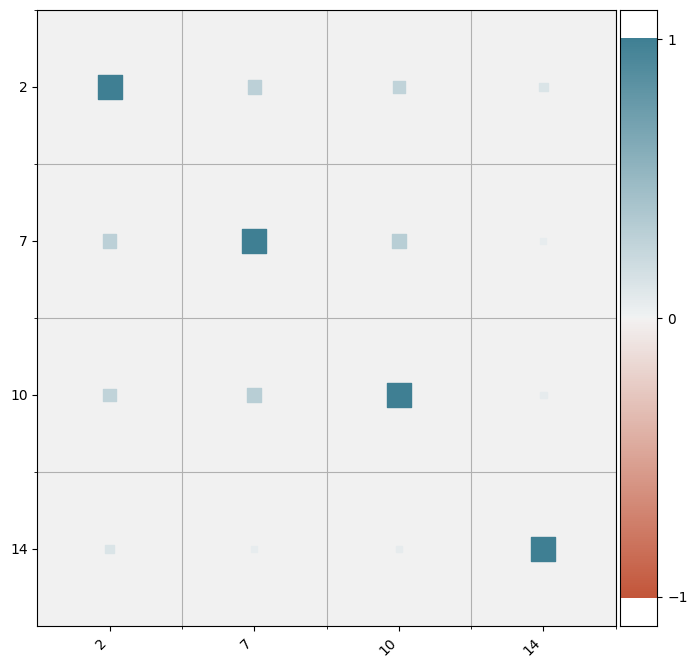

In [44]:
from heatmap import heatmap, corrplot
plt.figure(figsize=(8, 8))
corrplot(cc_apps.corr(numeric_only=True), size_scale=300);

In this plot we can see that there is not really much useful information except minor correlation between 2, 7 and 10.

Perhaps we can get more from categorical features. I looked at how you can do this and found this post https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables which suggests the code below to get such information. Will try it 

In [45]:
# from scipy.stats import chisquare
# df=df.apply(lambda x : pd.factorize(x)[0])+1
# pd.DataFrame([chisquare(df[x].values,f_exp=df.values.T,axis=1)[0] for x in df])


Unfortunately this fails so decided to look elsewhere and found this [Feature Selection Tutorial](https://www.datacamp.com/tutorial/feature-selection-python) - this also failed due to the mix of numeric and non numeric features. I then found this [Feature selection in machine learning using Lasso regression](https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a)

Here is an excerpt from the article:

> ### What is Lasso regression?
> I have already talked about Lasso regression in a previous blog post. Let me summarize the main properties of such a model. It is a linear model that uses this cost function:
>
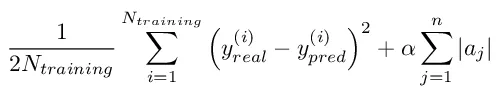
> 
> aj is the coefficient of the j-th feature. The final term is called l1 penalty and α is a hyperparameter that tunes the intensity of this penalty term. The higher the coefficient of a feature, the higher the value of the cost function. So, the idea of Lasso regression is to optimize the cost function reducing the absolute values of the coefficients. Obviously, this works if the features have been previously scaled, for example using standardization or other scaling techniques. α hyperparameter value must be found using a cross-validation approach.
>
> ### How can we use it for feature selection?
> Trying to minimize the cost function, Lasso regression will automatically select those features that are useful, discarding the useless or redundant features. In Lasso regression, discarding a feature will make its coefficient equal to 0.
>
> So, the idea of using Lasso regression for feature selection purposes is very simple: we fit a Lasso regression on a scaled version of our dataset and we consider only those features that have a coefficient different from 0. Obviously, we first need to tune α hyperparameter in order to have the right kind of Lasso regression.
>
> That’s pretty easy and will make us easily detect the useful features and discard the useless features.
>
> Let’s see how to do it in Python.

In [46]:
# import some libraries:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

# Our pipeline is made by a StandardScaler and the Lasso object itself.
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

# Now we have to optimize the α hyperparameter of Lasso regression. For this example, 
# we are going to test several values from 0.1 to 10 with 0.1 step. For each value, 
# we calculate the average value of the mean squared error in a 5-folds cross-validation
# and select the value of α that minimizes such average performance metrics. 
# We can use the GridSearchCV object for this purpose.
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

# Fit the grid search.
search.fit(X_train,y_train)



Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .................model__alpha=0.1;, score=-0.132 total time=   0.0s
[CV 2/5] END .................model__alpha=0.1;, score=-0.110 total time=   0.0s
[CV 3/5] END .................model__alpha=0.1;, score=-0.109 total time=   0.0s
[CV 4/5] END .................model__alpha=0.1;, score=-0.143 total time=   0.0s
[CV 5/5] END .................model__alpha=0.1;, score=-0.128 total time=   0.0s
[CV 1/5] END .................model__alpha=0.2;, score=-0.156 total time=   0.0s
[CV 2/5] END .................model__alpha=0.2;, score=-0.151 total time=   0.0s
[CV 3/5] END .................model__alpha=0.2;, score=-0.147 total time=   0.0s
[CV 4/5] END .................model__alpha=0.2;, score=-0.162 total time=   0.0s
[CV 5/5] END .................model__alpha=0.2;, score=-0.161 total time=   0.0s
[CV 1/5] END .model__alpha=0.30000000000000004;, score=-0.199 total time=   0.0s
[CV 2/5] END .model__alpha=0.30000000000000004;

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [47]:
# best value for α is:
search.best_params_

{'model__alpha': 0.1}

In [48]:
# get the values of the coefficients of Lasso regression.
coefficients = search.best_estimator_.named_steps['model'].coef_

In [49]:
# importance of a feature is the absolute value of its coefficient, so:
importance = np.abs(coefficients)

In [53]:
col_names = column_category_tf.transformers_[0][1].get_feature_names_out()
sample_row = X_train[0]

print(f'Length of a row = [{len(sample_row)}]')
print(f'Length of a column name list = [{len(col_names)}]')
print(f'Example of a row = [{" ".join([str(c) for c in sample_row])}]')
# b,23.08,2.5,u,g,c,v,1.085,t,t,11,t,g,00060,2184,+
for i, x in enumerate(sample_row): 
    name_of_col = col_names[i] if i < len(col_names) else 'unknown'
    imp = f' =====> {importance[i]}' if i < len(importance) and importance[i] > 0 else ''
    if imp != '':
        print(f'Column: {i:3} Value: {x:8} Name: {name_of_col} {imp}')
#     imp = f' =====> {x}' if x > 0 else ''
#     print(f'For column {X_train.columns[i]} {imp}')

Length of a row = [171]
Length of a column name list = [166]
Example of a row = [1.0 0.0 0.0 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 1.0 1.0 0.0 1.0 0.0 0.0 0.07412698412698415 0.3512435921777103 0.0605 0.05970149253731343 0.0054]
Column: 157 Value:      0.0 Name: x6_f  =====> 0.2563505098248835
Column: 159 Value:      0.0 Name: x7_f  =====> 0.01497276395844406


So it seems the columns with a high degree of importance are column 6 and 7 with a value of f in particular. Can we calidate this by looking at the actual model?

Let's try:

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

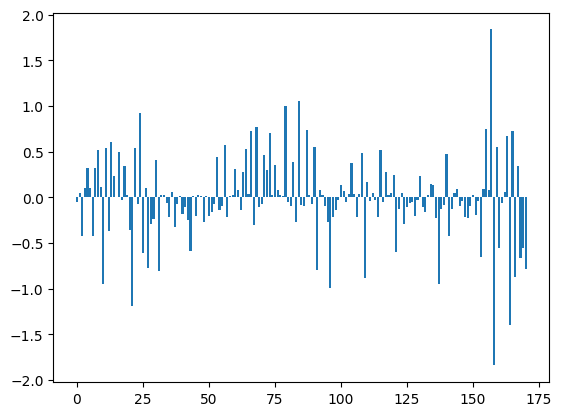

{'x6_f': 0.2563505098248835, 'x7_f': 0.01497276395844406}


In [58]:
importances = logreg.coef_[0]
crit_features = {}
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    if v > 0:
        crit_features[f'{col_names[i]}'] = v
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.show()
print(crit_features)